## [OpenCV-Python Tutorial] Segmentation

In this notebook, we will learn to use marker-based image segmentation using watershed algorithm

---

In [1]:
import numpy as np
import cv2 # OpenCV-Python
%matplotlib inline
import matplotlib.pyplot as plt

### 1. Finding an approximate estimate of the coins

For that, we can use [`cv2.threshold`](http://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html?highlight=threshold#threshold)

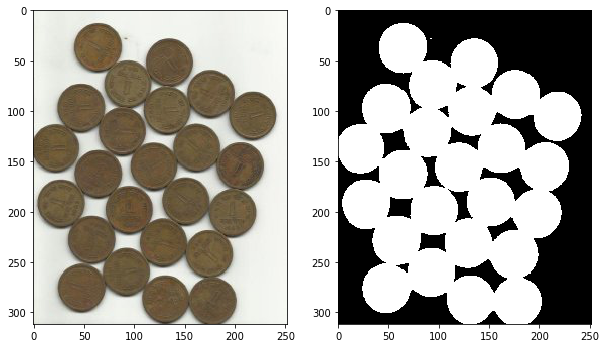

In [75]:
img = cv2.imread('../images/water_coins.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Binarize gray-scaled image
# cv2.threshold(grayimg, thresh, maxval, method)
# Args:
# - grayimg: input image (single-channel 8-bit or 32-bit floating point)
# - thresh: threshold value
# - maxval: maximum value to use with the cv2.THRESH_BINARY and cv2.THRESH_BINARY_INV thresholding method
# - method: thresholding types
#   - cv2.THRESH_BINARY
#   - cv2.THRESH_BINARY_INV
#   - cv2.THRESH_TRUNC
#   - cv2.THRESH_TOZERO
#   - cv2.THRESH_TOZERO_INV
#   - cv2.THRESH_OTSU
# Returns:
# - ret: used threshold value.
# - thresh: thresholded image
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.figure(figsize=(10, 6))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2); plt.imshow(thresh, cmap='gray')

### 2. Apply morphological transformations

Now we need to remove any small white noises in the image. For that we can use morphological transformations.

So, we first look at the morpholical transformations and apply it to our coin images.

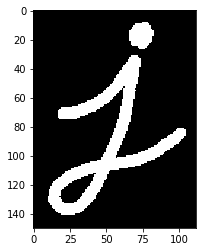

In [48]:
j_img = cv2.imread('../images/j.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(j_img, cmap='gray')

#### (1) Erosion

The basic idea of erosion is just like soil erosion only, it erodes away the boundaries of foreground object.

To do this, slide kernel through the image (as in 2D convolution).
A pixel in the original image (either 1 or 0) will be considered 1 only if all the pixels under the kernel is 1, otherwise it is eroded (made to zero)

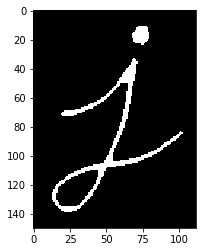

In [51]:
kernel = np.ones((5, 5), np.uint8)
erosion = cv2.erode(j_img, kernel, iterations=1)
plt.imshow(erosion, cmap='gray')

#### 2. Dilation

It is just opposite of erosion.

Here, a pixel elementis '1' if atleast one pixel under the kernel is '1'

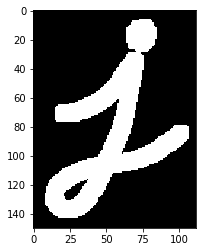

In [52]:
dilation = cv2.dilate(j_img,kernel,iterations = 1)
plt.imshow(dilation, cmap='gray')

#### 3. Opening

Opening is just another name of **erosion followed by dilation**.
It is useful in removing noise.
Erosion removes white noises, but it also shrinks our object.
Sow we dilate it.

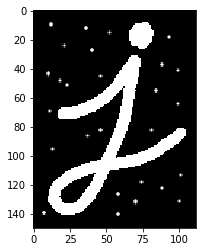

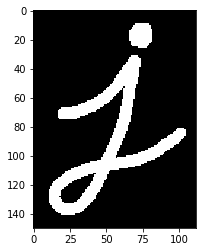

In [70]:
opening_img = cv2.imread('../images/opening.png', cv2.IMREAD_GRAYSCALE)[:, :112]
plt.figure()
plt.imshow(opening_img, cmap='gray')

opening = cv2.morphologyEx(opening_img, cv2.MORPH_OPEN, kernel)
plt.figure()
plt.imshow(opening, cmap='gray')

#### 4. Closing

Closing is reverse of Opening, **Dilation followed by Erosion**.
It is useful in closing small holes inside the foreground objects, or small black points on the object.

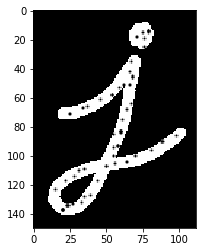

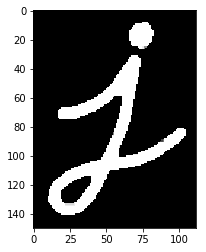

In [71]:
closing_img = cv2.imread('../images/closing.png', cv2.IMREAD_GRAYSCALE)[:, :112]
plt.figure()
plt.imshow(closing_img, cmap='gray')

closing = cv2.morphologyEx(closing_img, cv2.MORPH_CLOSE, kernel)
plt.figure()
plt.imshow(closing, cmap='gray')

Now, let's apply morphological transformation to our images!

First, remove noise and plot

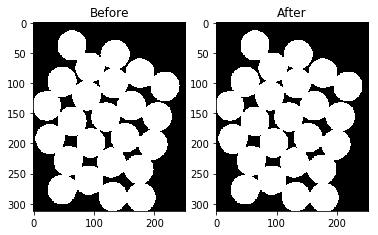

In [76]:
# Noise removal
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
plt.subplot(1, 2, 1); plt.imshow(thresh, cmap='gray'); plt.title('Before')
plt.subplot(1, 2, 2); plt.imshow(opening, cmap='gray'); plt.title('After')

Then, extract sure foreground areas

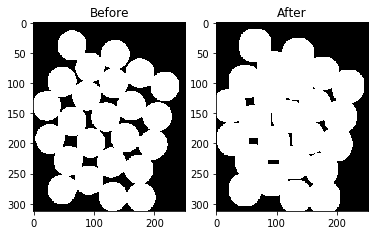

In [77]:
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
plt.subplot(1, 2, 1); plt.imshow(opening, cmap='gray'); plt.title('Before')
plt.subplot(1, 2, 2); plt.imshow(sure_bg, cmap='gray'); plt.title('After')

We need to extract the area which we are sure they are coins.
Erosion removes the boundary pixels.
So whatever remaining, we can be sure it is coin.
But since they are touching each other, another good option would be to find the distance transform and apply a proper threshold.

We will use [dst = `cv2.distanceTransform(src, distanceType, maskSize)'](http://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#distancetransform)

It Calculates the distance to the closest zero pixel for each pixel of the source image.

Args
- `src`: 8-bit, single-channel source image
- `distanceType`: Type of distance. It can be `cv2.CV_DIST_L1`, `cv2.CV_DIST_L2`, `cv2.CV_DIST_C`
- `maskSize`: Size of the distance transform mask. It can be 3 or 5

Returns
- `dst`: Output image with calculated distances

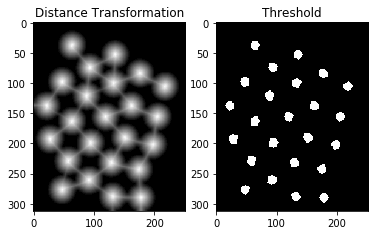

In [82]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

plt.subplot(1,2,1); plt.imshow(dist_transform, cmap='gray'); plt.title('Distance Transformation')
plt.subplot(1,2,2); plt.imshow(sure_fg, cmap='gray'); plt.title('Threshold')

The remaining regions are those which we don't have any idea, whether it is coins or background.
Watershed algorithm should find it.

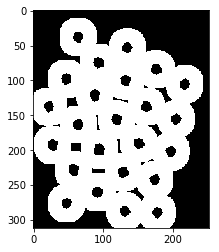

In [85]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(unknown, cmap='gray')

Now we create marker and label the regions inside it.
We will use `cv2.connectedComponents()`.
It labels background of the image with 0, then other objects are labelled with integers starting from 1

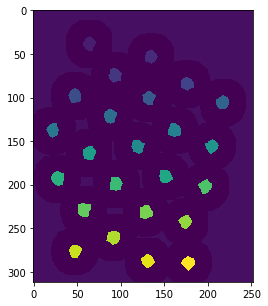

In [95]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

plt.figure(figsize=(7,5))
plt.imshow(markers)

Now our marker is ready.
It is time for final step, apply watershed.
The boundary region will be marked with -1.

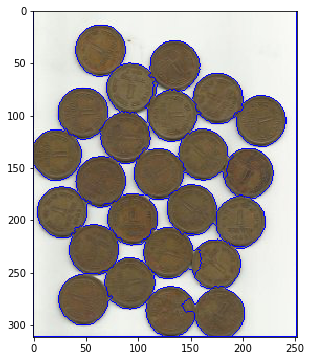

In [96]:
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

plt.figure(figsize=(5, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

#### Reference

Please see the following official tutorials for more detailed explanation.

- [Image Segmentation with Watershed Algorithm - OpenCV documentation](http://docs.opencv.org/3.2.0/d3/db4/tutorial_py_watershed.html)